# Serbia Energy Optimisation

This notebook is for analysing the results of optimisation of Serbian power plants in the context of new distributed solar power generation. The problem to be solved is to decide what production each plant should produce for each hour. 

Thus, it is the *unit commitment problem*. We have 24 plants, including a hypothetical decentalised solar power plant composed of many small solar units at the domestic level. We take the demand curve of a typical day and try to match it closely with the total supply. We try to minimize:

* production cost
* emissions
* sustainability cost
* environmental cost

We have used a weighting to combine these objectives to a single objective. We have used linear programming (LP) to optimise schedules. We have used three approaches -- grid search, random search, and multiobjective evolutionary search -- to explore weightings. Each leads to a Pareto front of schedules, trading-off the objectives against each other. In this notebook, we read in all the data and investigate the distributions of the above objectives, and visualise the Pareto front among them.

## Implementation

The file `run.py` contains the implementation. It reads data from several `.csv` files. We have run the optimizer many times with different weights on the above objectives, and different seeds. This notebook only carries out analysis.

First, we import all the usual Python data/visualisation libraries.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
plant_info = pd.read_csv("data/plant_info_10.csv")

In [3]:
s = plant_info.to_latex(float_format="%.3f", 
                    index=False,
                    columns=["name", "type", "production_cost", "environment_cost", "sustainability_cost", "CO2", "lower_bound", "upper_bound", "distance"],
                    header=["Name", "Type", "Prod cost", "Env cost", "Sus cost", "Emissions", "LB", "UB", "Distance"]
                   )
print(s)

\begin{tabular}{llrrrrrrr}
\toprule
              Name &           Type & Prod cost & Env cost & Sus cost & Emissions &   LB &    UB & Distance \\
\midrule
            Vrla 1 &          hydro &     1.400 &    0.010 &    0.700 &     0.024 &   10 &    50 &  178.830 \\
            Vrla 2 &          hydro &     1.400 &    0.010 &    0.700 &     0.024 &    5 &    24 &  175.470 \\
            Vrla 3 &          hydro &     1.400 &    0.010 &    0.700 &     0.024 &    6 &    29 &  171.320 \\
            Vrla 4 &          hydro &     1.400 &    0.010 &    0.700 &     0.024 &    5 &    25 &  166.940 \\
          HE Pirot &          hydro &     1.400 &    0.010 &    0.700 &     0.024 &   16 &    80 &  162.140 \\
            HEDJ 1 &          hydro &     1.400 &    0.010 &    0.700 &     0.024 &  205 &  1026 &  152.780 \\
            HEDJ 2 &          hydro &     1.400 &    0.010 &    0.700 &     0.024 &   54 &   270 &  138.400 \\
       Ovčar Banja &          hydro &     1.400 &    0.010 &    0.7

In [4]:
demand = pd.read_csv("data/demand.csv", names=["demand"])

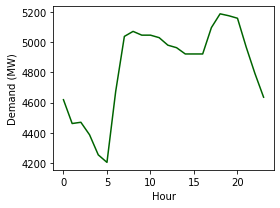

In [5]:
plt.figure(figsize=(4, 3))
sns.lineplot(demand.index, demand["demand"] / 1000, color="darkgreen", ax=plt.gca())
plt.xlabel("Hour")
plt.ylabel("Demand (MW)")
plt.tight_layout()
plt.savefig("demand_curve.pdf")

The following calculates the Pareto front, given a 2D array, where each row is a point and each column is an objective.

In [6]:
# https://stackoverflow.com/questions/32791911/fast-calculation-of-pareto-front-in-python

# Fairly fast for many datapoints, less fast for many costs, somewhat readable
def is_pareto_efficient_simple(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient]<c, axis=1)  # Keep any point with a lower cost
            is_efficient[i] = True  # And keep self
    return is_efficient


The following function reads a directory of data files, applies an optional filter to filter out points which are not worth considering, and creates the Pareto front as a Pandas DataFrame.

In [7]:
def get_pareto_front(d, algo, obj_names, filter_fn=None):
    costs = []
    filenames = []
    for f in os.listdir(d):
        if f.startswith("objvals_algo_%s" % algo):
            df = os.path.join(d, f)
            txt = open(df).read()
            result = eval(txt)
            if filter_fn:
                if filter_fn(result): 
                    continue
            c = [result[k] for k in obj_names]
            costs.append(c)
            filenames.append(f)
    costs = np.array(costs)
    pe = is_pareto_efficient_simple(costs)
    df = pd.DataFrame(costs[pe], columns=obj_names)
    filenames = np.array(filenames)
    filenames = filenames[pe] # list of filenames of points in PF
    return df, filenames

In the following cell we customise to our problem. We list the four objectives of interest.

In [8]:
obj_names = [
    "technology_cost",
    "emissions",
    "env_cost",
    "sus_cost",
]

In the next cell, we read in the `objvals` results representing the Pareto front from each run, and get all the data into a single dataframe.

In [90]:
single_pfs = []
pfs_by_solar = {}
algos = ["grid_search", "random_search", "pareto_archive"]
for algo in algos:
    for solar in (0, 10, 50, 100):
        d = f"results/{algo}/solar_{solar}/"
        pf, filenames = get_pareto_front(d, algo, obj_names, None)
        pf["solar_size"] = solar
        pf["filename"] = filenames
        pf["algo"] = algo
        pf.columns = ["Production cost", "Emissions", "Environmental cost", "Sustainability cost", "New solar size (MW)", "filename", "algo"]
        single_pfs.append(pf)
combined_pf = pd.concat(single_pfs)

Next we create a table of the PF of results for each algo, each solar value.

In [23]:
for algo in algos:
    for solar in (0, 10, 50, 100):
        pf = combined_pf[(combined_pf["algo"] == algo) & (combined_pf["New solar size (MW)"] == solar)]
        print(r"\begin{table}")
        caption = r"\caption{"
        label = r"\label{"
        end = r"}}"
        print(rf"{caption}Algorithm {algo}. New solar size {solar}MW{label}tab:pareto_tab_{algo}_{solar}{end}")
        print(pf.to_latex(float_format="%.3e", 
                          index=True,
                          columns=["Production cost", "Emissions", "Environmental cost", "Sustainability cost"],
                          header=["Prod cost", "Emissions", "Env cost", "Sus cost"],
                         ))
        print(r"\end{table}")


\begin{table}
\caption{Algorithm grid_search. New solar size 0MW\label{tab:pareto_tab_grid_search_0}}
\begin{tabular}{lrrrr}
\toprule
{} & Prod cost & Emissions &  Env cost &  Sus cost \\
\midrule
0 & 4.885e+08 & 7.365e+07 & 1.351e+08 & 2.132e+08 \\
1 & 4.929e+08 & 7.287e+07 & 1.341e+08 & 2.124e+08 \\
2 & 4.926e+08 & 7.287e+07 & 1.341e+08 & 2.124e+08 \\
3 & 4.858e+08 & 7.488e+07 & 1.370e+08 & 2.147e+08 \\
4 & 4.860e+08 & 7.464e+07 & 1.366e+08 & 2.144e+08 \\
5 & 4.863e+08 & 7.449e+07 & 1.364e+08 & 2.142e+08 \\
6 & 4.926e+08 & 7.287e+07 & 1.341e+08 & 2.125e+08 \\
7 & 4.859e+08 & 7.473e+07 & 1.367e+08 & 2.145e+08 \\
8 & 4.858e+08 & 7.479e+07 & 1.368e+08 & 2.146e+08 \\
9 & 4.883e+08 & 7.373e+07 & 1.353e+08 & 2.133e+08 \\
\bottomrule
\end{tabular}

\end{table}
\begin{table}
\caption{Algorithm grid_search. New solar size 10MW\label{tab:pareto_tab_grid_search_10}}
\begin{tabular}{lrrrr}
\toprule
{} & Prod cost & Emissions &  Env cost &  Sus cost \\
\midrule
0  & 4.882e+08 & 7.342e+07 & 1.347e

Next, we create a PairGrid plot which shows a scatterplot (bivariate distribution) for each pair of variables. On the diagonal we show the univariate distribution.

The next cell defines the main graph we want to make -- a PairGrid.

In [9]:
def make_pf_pairgrid(pf, algo):
    def diagfunc(x, **kws):
        ax = plt.gca()
        if kws["label"] == 0:
            ax.annotate("Best", xy=(0.1, 0.4), xycoords=ax.transAxes)
        ax.axvline(x=x.min(), ymin=0, ymax=0.3, linewidth=4, color=kws["color"])

    g = sns.PairGrid(pf, 
                     vars=["Production cost", "Emissions", "Environmental cost", "Sustainability cost"], 
                     hue="New solar size (MW)",
                     palette=sns.cubehelix_palette(4, start=.5, rot=-.75, light=0.7, reverse=True),
                     #palette=sns.color_palette("Set2"),
                     height=3, aspect=0.85
                    )
    g = g.map_diag(diagfunc)
    g = g.map_offdiag(plt.scatter, alpha=1, lw=0)
    g = g.add_legend()
    g._legend.set_bbox_to_anchor((0.25, 0.9))
    plt.tight_layout()
    plt.savefig(f"pareto_front_pairgrid_{algo}.pdf")
    plt.show()
    plt.close()

We see that a nice Pareto Front is formed between `production_cost` and `emissions`, showing that they trade-off against each other.

We also see that `emissions`, `env_cost` and `sus_cost` are closely correlated.

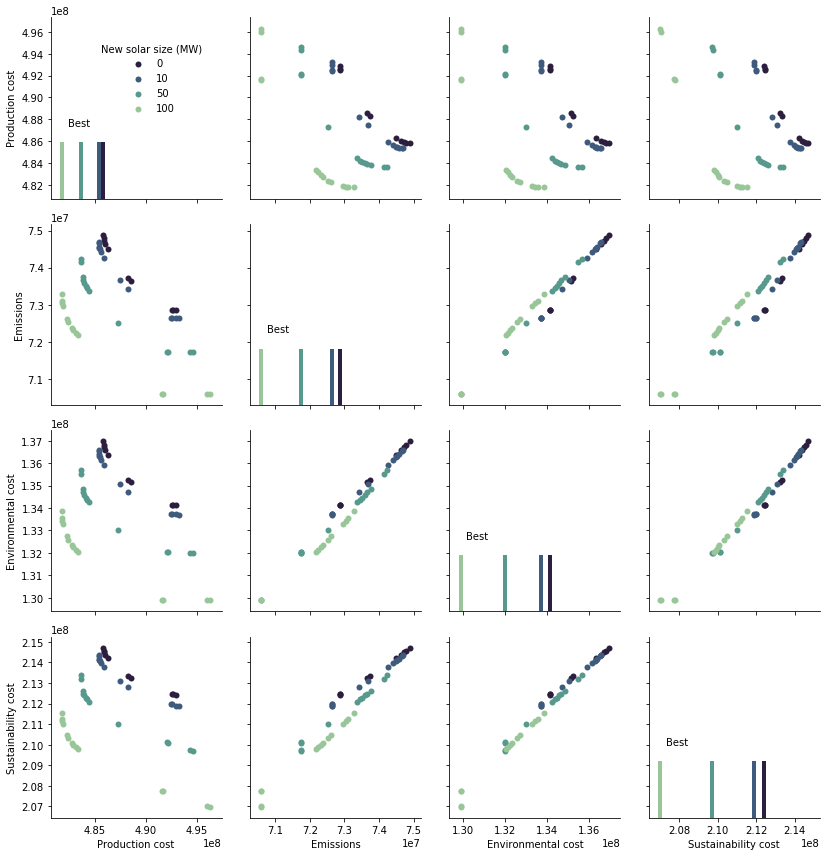

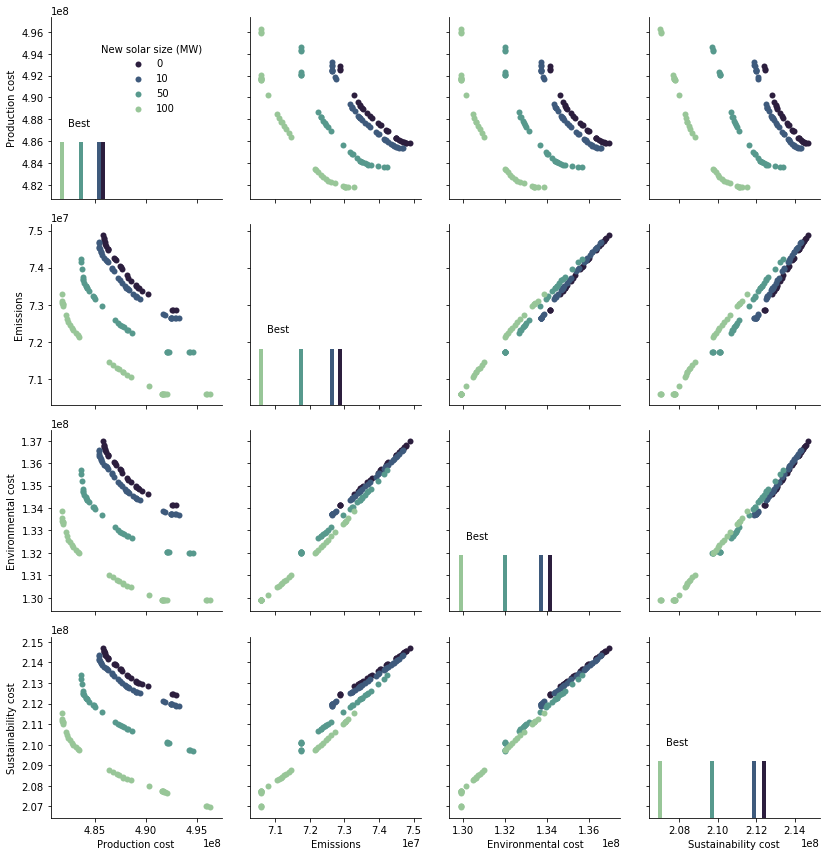

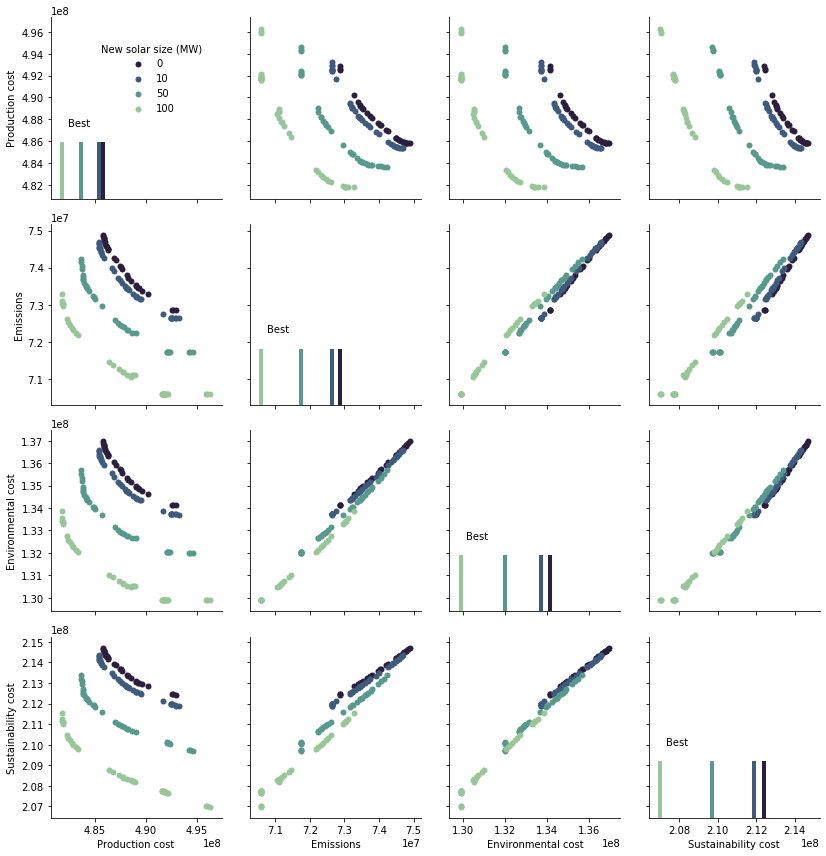

In [24]:
for algo in algos:
    pf = combined_pf[combined_pf["algo"] == algo]
    # print(pf)
    make_pf_pairgrid(pf, algo)

In the following, we print out exact results for the single best point on each individual objective. We don't expect these points to be competitive when judged on multiple objectives simultaneously.

In [27]:
for solar in (0, 10, 50, 100):
    algo = "pareto_archive"
    pf = combined_pf[(combined_pf["algo"] == algo) & (combined_pf["New solar size (MW)"] == solar)]
    print(f"SOLAR {solar} ######################")
    for k in ["Production cost", "Emissions", "Environmental cost", "Sustainability cost"]:
        i = pf[k].idxmin()
        print("Best", k, ", at row", i)
        print(pf.iloc[i])
        print("")

SOLAR 0 ######################
Best Production cost , at row 0
Production cost                                             4.85834e+08
Emissions                                                   7.48835e+07
Environmental cost                                          1.36971e+08
Sustainability cost                                         2.14711e+08
New solar size (MW)                                                   0
filename               objvals_algo_pareto_archive_solar_0_seed_0_0.dat
algo                                                     pareto_archive
Name: 0, dtype: object

Best Emissions , at row 1
Production cost                                             4.92647e+08
Emissions                                                   7.28664e+07
Environmental cost                                          1.34137e+08
Sustainability cost                                         2.12444e+08
New solar size (MW)                                                   0
filename               

We would like to compare the best possible value on each objective, between 0MW and 100MW.

In [89]:
def improvement_percent(x, y):
    return 100 * (x - y) / x
algo = "pareto_archive"
pf0 = combined_pf[(combined_pf["algo"] == algo) & (combined_pf["New solar size (MW)"] == 0)]
pf100 = combined_pf[(combined_pf["algo"] == algo) & (combined_pf["New solar size (MW)"] == 100)]
tab = []
for k in ["Production cost", "Emissions", "Environmental cost", "Sustainability cost"]:
    v0 = pf0[k].min()
    v100 = pf100[k].min()
    tab.append((k, v0, v100, str(round(improvement_percent(v0, v100), 1))))
df = pd.DataFrame(tab, columns=["Objective", "best (0MW)", "best (100MW)", "improvement (%)"])
print(df.to_latex(float_format="%.3e", 
                          index=False))

\begin{tabular}{lrrl}
\toprule
           Objective &  best (0MW) &  best (100MW) & improvement (\%) \\
\midrule
     Production cost &   4.858e+08 &     4.818e+08 &             0.8 \\
           Emissions &   7.287e+07 &     7.059e+07 &             3.1 \\
  Environmental cost &   1.341e+08 &     1.299e+08 &             3.2 \\
 Sustainability cost &   2.124e+08 &     2.070e+08 &             2.6 \\
\bottomrule
\end{tabular}



Next we are going to plot some schedules as heatmaps.

First we find the two schedules of min Env cost (for 0MW and 100MW), and then same for min Production cost - these are is to demonstrate how the extra 100MW changes things.

In [52]:
solar = 0
algo = "pareto_archive"
pf = combined_pf[(combined_pf["algo"] == algo) & (combined_pf["New solar size (MW)"] == solar)]
pf[
    (pf["Environmental cost"] == pf["Environmental cost"].min())
  ]



,Production cost,Emissions,Environmental cost,Sustainability cost,New solar size (MW),filename,algo
12,4.929274e+08,7.286668e+07,1.341367e+08,2.124108e+08,0,objvals_algo_pareto_archive_solar_0_seed_0_2.dat,pareto_archive


In [53]:
solar = 100 # 100MW
algo = "pareto_archive"
pf = combined_pf[(combined_pf["algo"] == algo) & (combined_pf["New solar size (MW)"] == solar)]
pf[
    (pf["Environmental cost"] == pf["Environmental cost"].min())
  ]

,Production cost,Emissions,Environmental cost,Sustainability cost,New solar size (MW),filename,algo
22,4.963123e+08,7.059351e+07,1.298906e+08,2.069894e+08,100,objvals_algo_pareto_archive_solar_100_seed_0_3...,pareto_archive


In [65]:
solar = 100 # 100MW
algo = "pareto_archive"
pf = combined_pf[(combined_pf["algo"] == algo) & (combined_pf["New solar size (MW)"] == solar)]
pf[
    (pf["Production cost"] == pf["Production cost"].min())
  ]

,Production cost,Emissions,Environmental cost,Sustainability cost,New solar size (MW),filename,algo
0,4.817631e+08,7.328562e+07,1.338606e+08,2.115401e+08,100,objvals_algo_pareto_archive_solar_100_seed_0_0...,pareto_archive


Next we find two schedules on opposite sides of a "gap" in the 100MW PF. This is to demonstrate the step-change in strategy.

In [59]:
solar = 100
algo = "pareto_archive"
pf = combined_pf[(combined_pf["algo"] == algo) & (combined_pf["New solar size (MW)"] == solar)]
pf[
    (4.832e8 < pf["Production cost"]) & (pf["Production cost"] < 4.85e8) # LHS of the gap
  ]



,Production cost,Emissions,Environmental cost,Sustainability cost,New solar size (MW),filename,algo
3,4.833222e+08,7.217694e+07,1.320554e+08,2.098108e+08,100,objvals_algo_pareto_archive_solar_100_seed_0_1...,pareto_archive


In [61]:
solar = 100 # 100MW
algo = "pareto_archive"
pf = combined_pf[(combined_pf["algo"] == algo) & (combined_pf["New solar size (MW)"] == solar)]
pf[
    (4.85e8 < pf["Production cost"]) & (pf["Production cost"] < 4.865e8) # RHS of the gap
  ]

,Production cost,Emissions,Environmental cost,Sustainability cost,New solar size (MW),filename,algo
17,4.863800e+08,7.146196e+07,1.310240e+08,2.087913e+08,100,objvals_algo_pareto_archive_solar_100_seed_0_2...,pareto_archive


min_env_cost_0MW
relative_supply_algo_pareto_archive_solar_0_seed_0_2.csv
min_env_cost_100MW
relative_supply_algo_pareto_archive_solar_100_seed_0_3.csv
min_prod_cost_100MW
relative_supply_algo_pareto_archive_solar_100_seed_0_0.csv
LHS_of_gap_100MW
relative_supply_algo_pareto_archive_solar_100_seed_0_11.csv
RHS_of_gap_100MW
relative_supply_algo_pareto_archive_solar_100_seed_0_25.csv


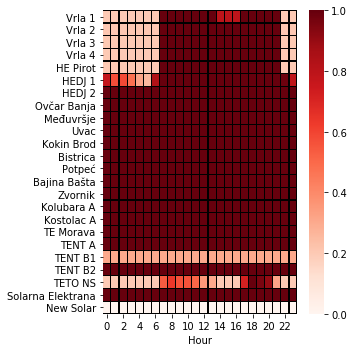

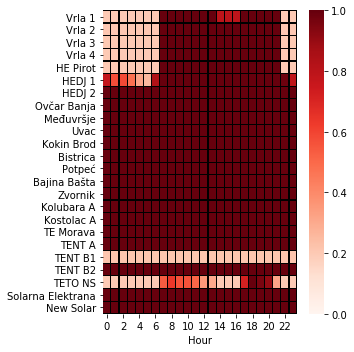

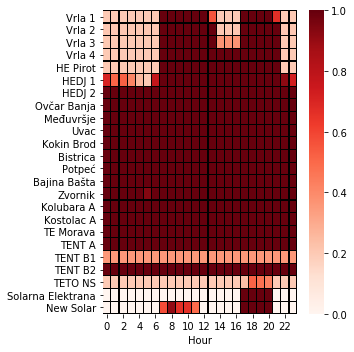

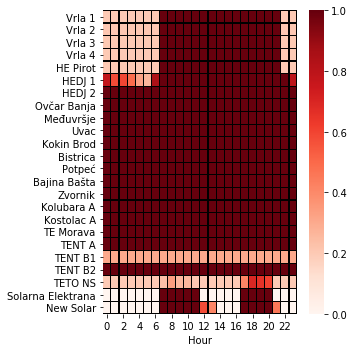

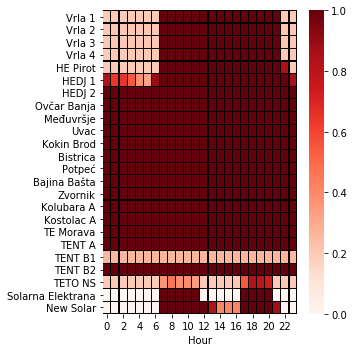

In [69]:
to_do = [(0, 12, "min_env_cost_0MW"),
         (100, 22, "min_env_cost_100MW"),
         (100, 0, "min_prod_cost_100MW"),
         (100, 3, "LHS_of_gap_100MW"),
         (100, 17, "RHS_of_gap_100MW")]
seed = 0

for solar, idx, title in to_do:
    algo = "pareto_archive"
    pf = combined_pf[(combined_pf["algo"] == algo) & (combined_pf["New solar size (MW)"] == solar)]
    f = pf.iloc[idx]["filename"]
    f = f.replace("objvals", "relative_supply").replace(".dat", ".csv")
    d = f"results/{algo}/solar_{solar}"
    print(title)
    print(f)
    plt.figure(figsize=(5,5))
    xbest = np.genfromtxt(os.path.join(d, f), delimiter=" ")
    plant_info = pd.read_csv("data/plant_info.csv")
    heatmap = sns.heatmap(xbest, cmap="Reds", linewidths=0.1, linecolor="k", vmin=0, vmax=1);
    heatmap.set_xlabel("Hour")
    heatmap.set_yticklabels(plant_info["name"], rotation=0);
    plt.tight_layout()
    plt.savefig(f"schedule_{algo}_{solar}_{idx}_{title}.pdf")

In [80]:
fronts = np.load("generations.npy", allow_pickle=True)

In [85]:
def make_plots(filename, fronts, xlabel=None, ylabel=None):

    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(11, 3))

    n = len(fronts)
    idxs = (0, 1, 3, n-1)
    for i, idx in enumerate(idxs):
        
        costs = fronts[idx]
        ax[i].scatter(costs[:, 0], costs[:, 1], label=f"Gen {idx}, size {len(costs)}")
        ax[i].set_xlabel(xlabel if xlabel else "x")
        
        #ax[i].text(0.6, 0.8, f"Gen {idx}", transform=ax[i].transAxes)
        ax[i].legend()
        
    for i, idx in enumerate(idxs[:-1]):
        ax[i].set_xlim(ax[-1].get_xlim())
        ax[i].set_ylim(ax[-1].get_ylim())
        
    ax[0].set_ylabel(ylabel if ylabel else "y")
    plt.tight_layout()
    plt.savefig(filename)


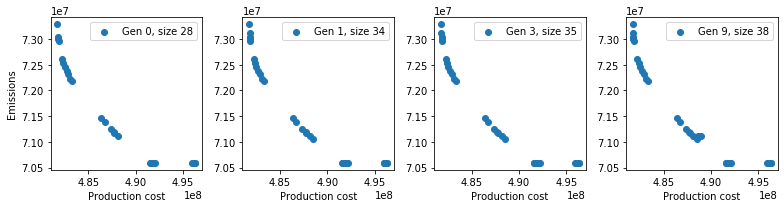

In [86]:
make_plots("generations.pdf", fronts, "Production cost", "Emissions")